In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt

from pylab import rcParams
from IPython.display import display

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn')

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
data = pd.read_csv('data/btc.csv')
display(data)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [4]:
data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
data.index = data.Timestamp
data = data.resample('M').mean()
series = data[['Weighted_Price']]
display(data)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-31,6.345389,6.348982,6.341218,6.346148,4.031777,25.168238,6.345955
2012-02-29,5.230208,5.231646,5.227036,5.228510,8.313993,42.239422,5.228443
2012-03-31,4.985481,4.986695,4.982580,4.983828,15.197791,76.509751,4.984397
2012-04-30,4.995171,4.996447,4.993763,4.995079,21.683913,108.218094,4.995091
...,...,...,...,...,...,...,...
2020-11-30,16535.778528,16545.663704,16525.571002,16536.023486,6.695166,111021.991229,16535.990325
2020-12-31,21811.751812,21826.119052,21796.889787,21812.155606,5.742400,129237.684380,21811.782847
2021-01-31,34554.125793,34594.169353,34512.497779,34554.252479,10.253061,352510.183906,34552.337249


In [5]:
display(series.head(n = 10))

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-31,6.345955
2012-02-29,5.228443
2012-03-31,4.984397
2012-04-30,4.995091
2012-05-31,5.046848
2012-06-30,6.047198
2012-07-31,7.907613
2012-08-31,10.984670


In [6]:
display(series.tail(n = 10))

,Weighted_Price
Timestamp,
2020-06-30,9459.783762
2020-07-31,9558.816690
2020-08-31,11637.963222
2020-09-30,10656.147579
2020-10-31,11844.141987
2020-11-30,16535.990325
2020-12-31,21811.782847
2021-01-31,34552.337249
2021-02-28,46075.783298


In [7]:
series.describe()

,Weighted_Price
count,112.000000
mean,4572.087125
std,8189.423023
min,4.471603
25%,242.052684
50%,658.975739
75%,7195.809819
max,54499.282182


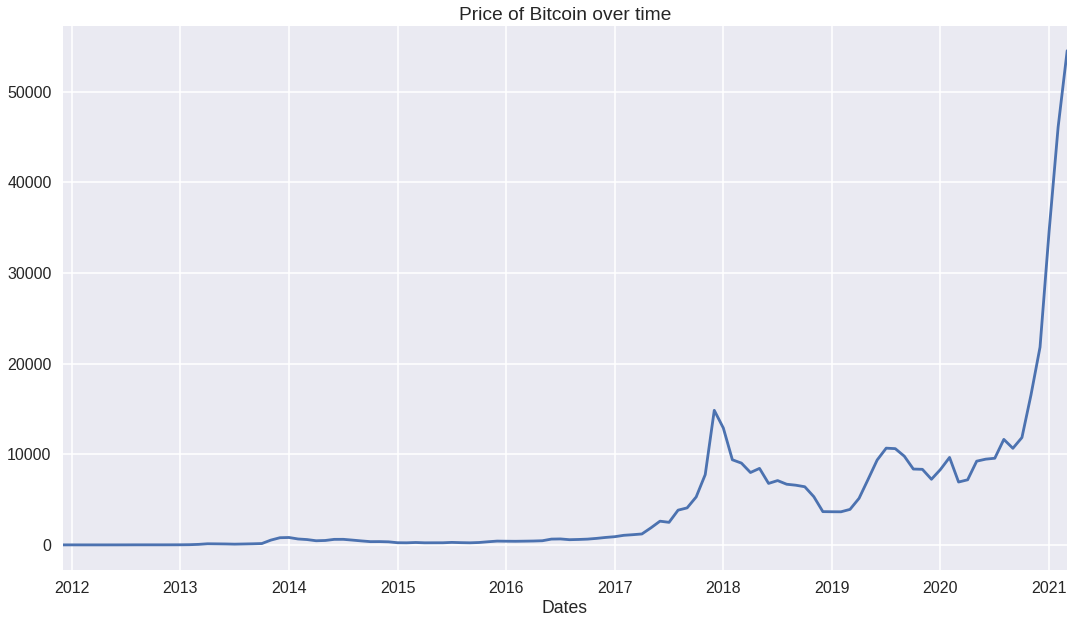

In [8]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (18, 10))
plt.title("Price of Bitcoin over time")
series['Weighted_Price'].plot()
plt.xlabel("Dates")
plt.show()

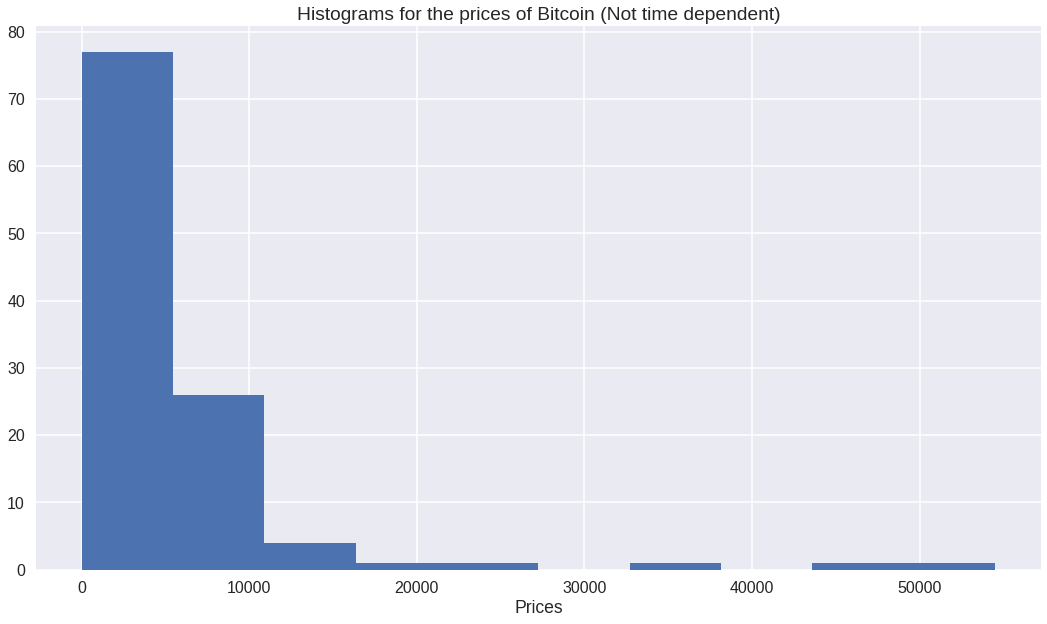

In [9]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (18, 10))
plt.title("Histograms for the prices of Bitcoin (Not time dependent)")
series['Weighted_Price'].hist()
plt.xlabel("Prices")
plt.show()

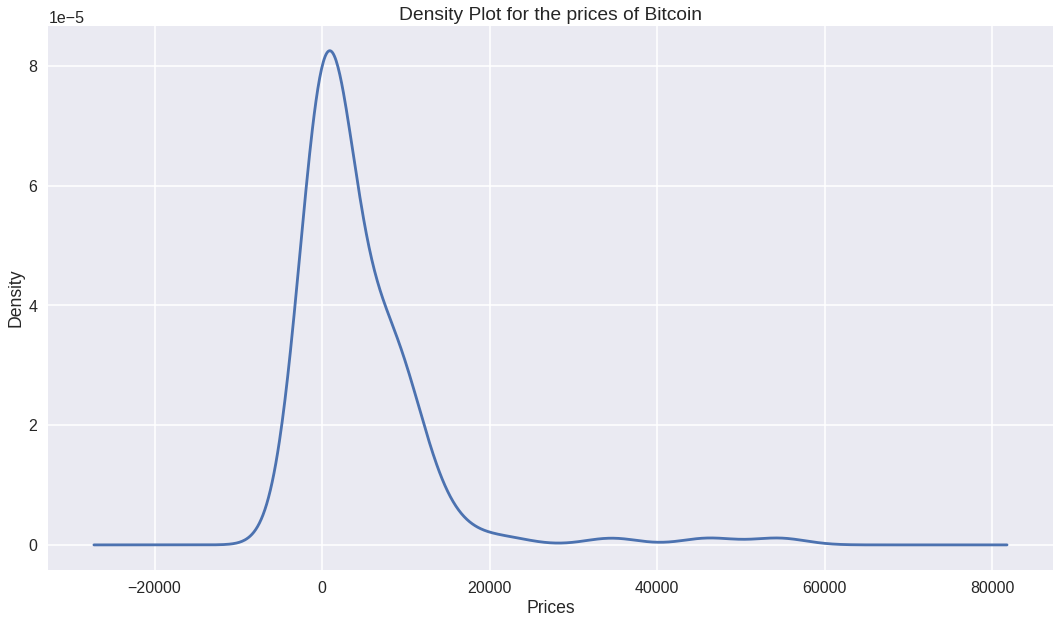

In [10]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (18, 10))
plt.title("Density Plot for the prices of Bitcoin")
series['Weighted_Price'].plot(kind = 'kde')
plt.xlabel("Prices")
plt.show()

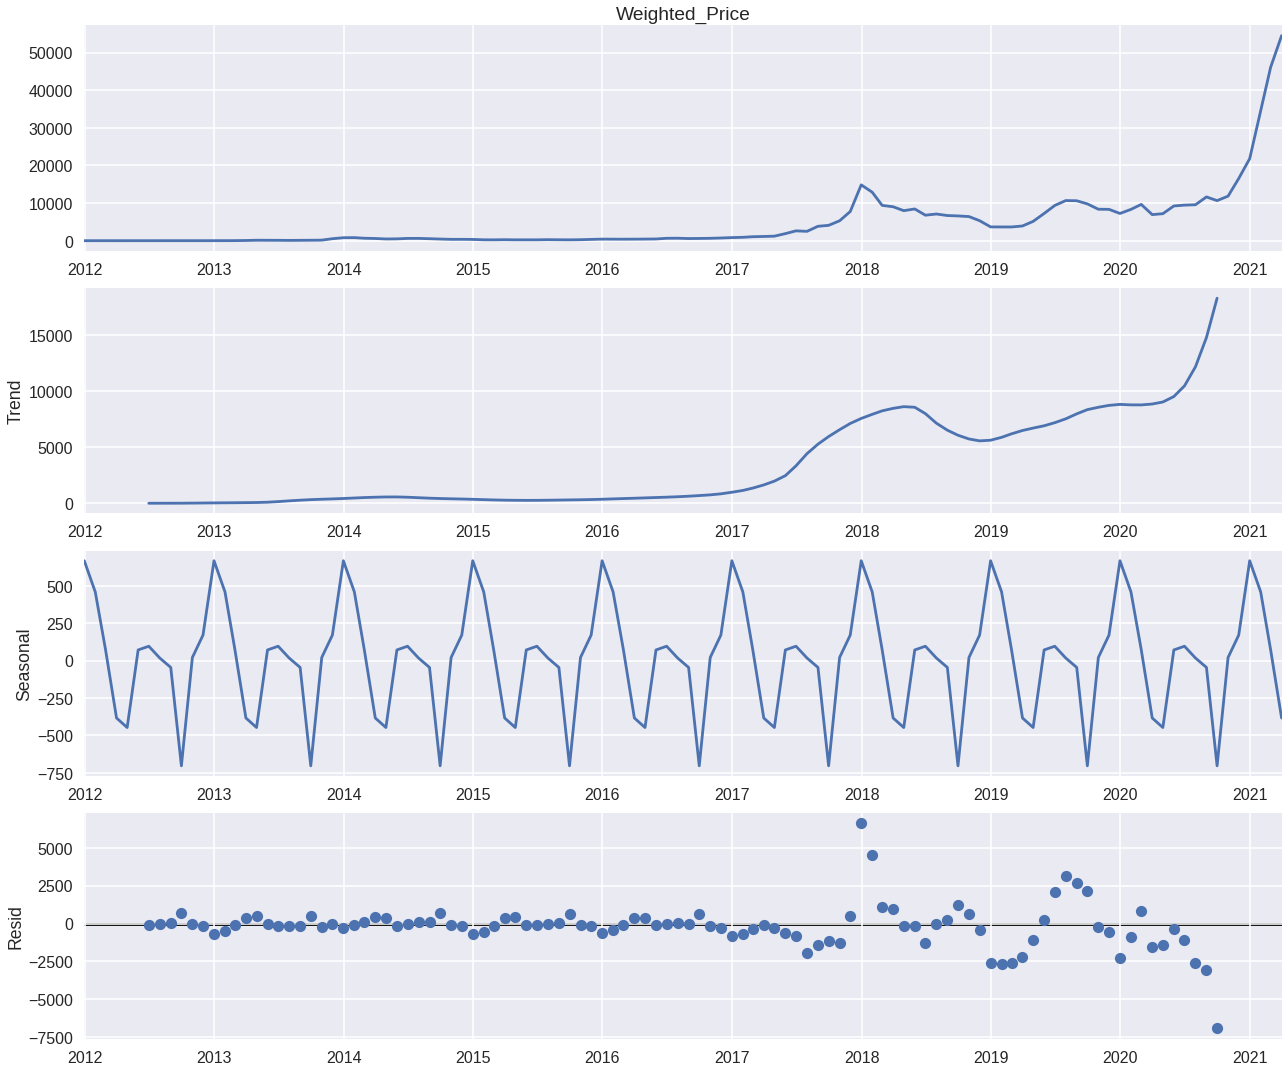

In [11]:
decomposition = seasonal_decompose(series['Weighted_Price'], model = 'additive')
rcParams['figure.figsize'] = 18, 15
decomposition.plot()
plt.show()

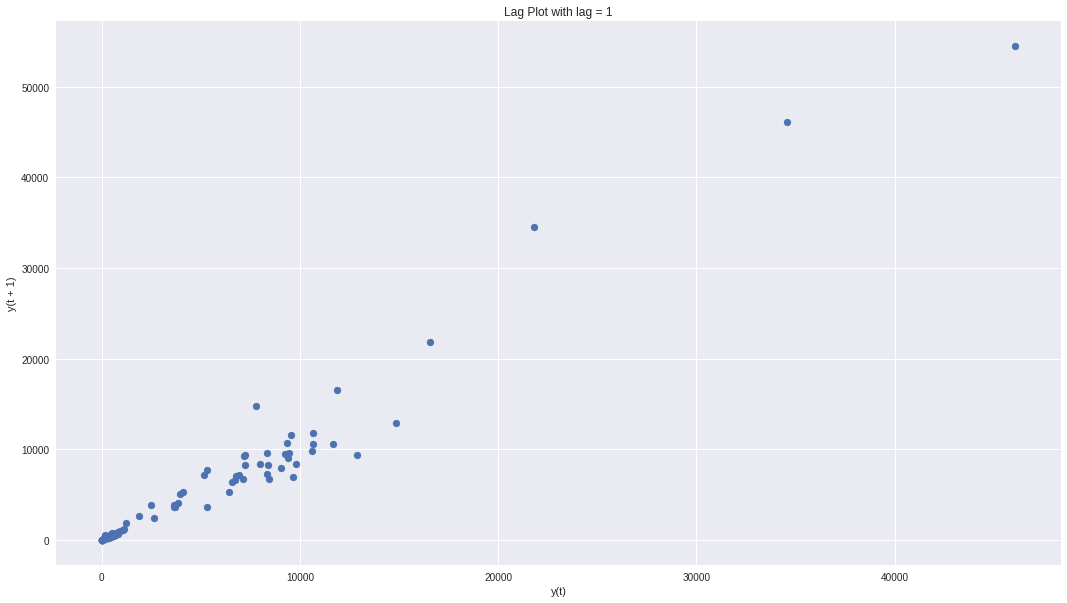

In [12]:
plt.style.use('seaborn')
plt.figure(figsize = (18, 10))
pd.plotting.lag_plot(series['Weighted_Price'])
plt.title("Lag Plot with lag = 1")
plt.show()

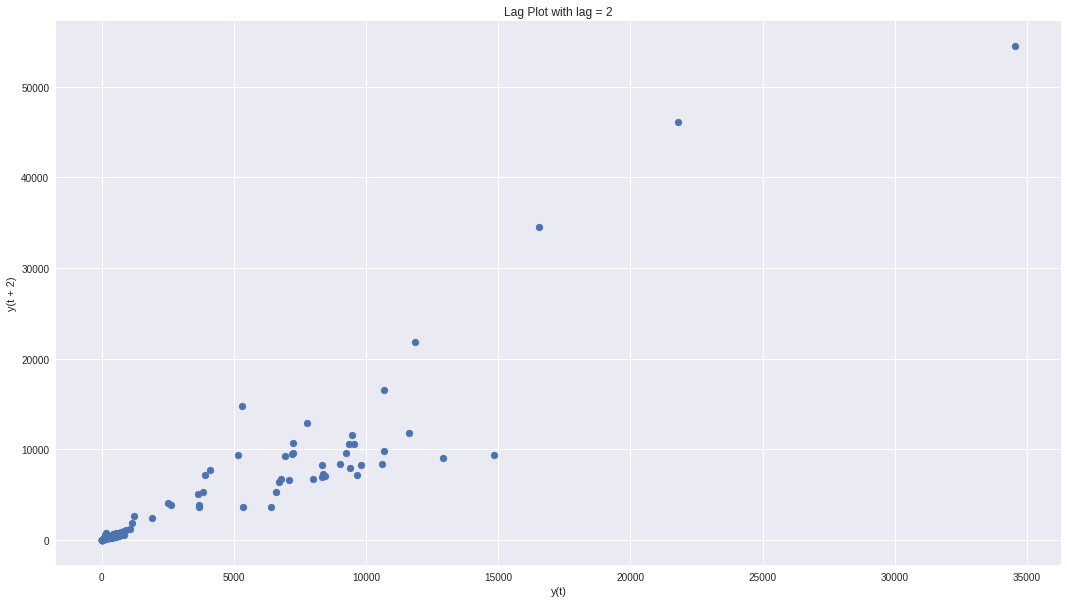

In [13]:
plt.style.use('seaborn')
plt.figure(figsize = (18, 10))
pd.plotting.lag_plot(series['Weighted_Price'], lag = 2)
plt.title("Lag Plot with lag = 2")
plt.show()

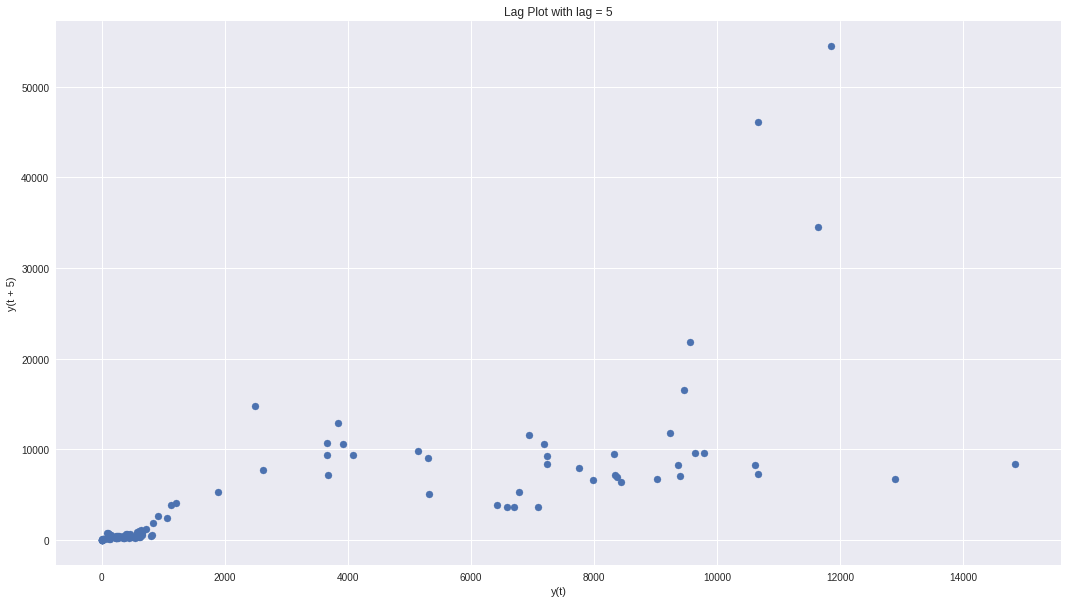

In [14]:
plt.style.use('seaborn')
plt.figure(figsize = (18, 10))
pd.plotting.lag_plot(series['Weighted_Price'], lag = 5)
plt.title("Lag Plot with lag = 5")
plt.show()

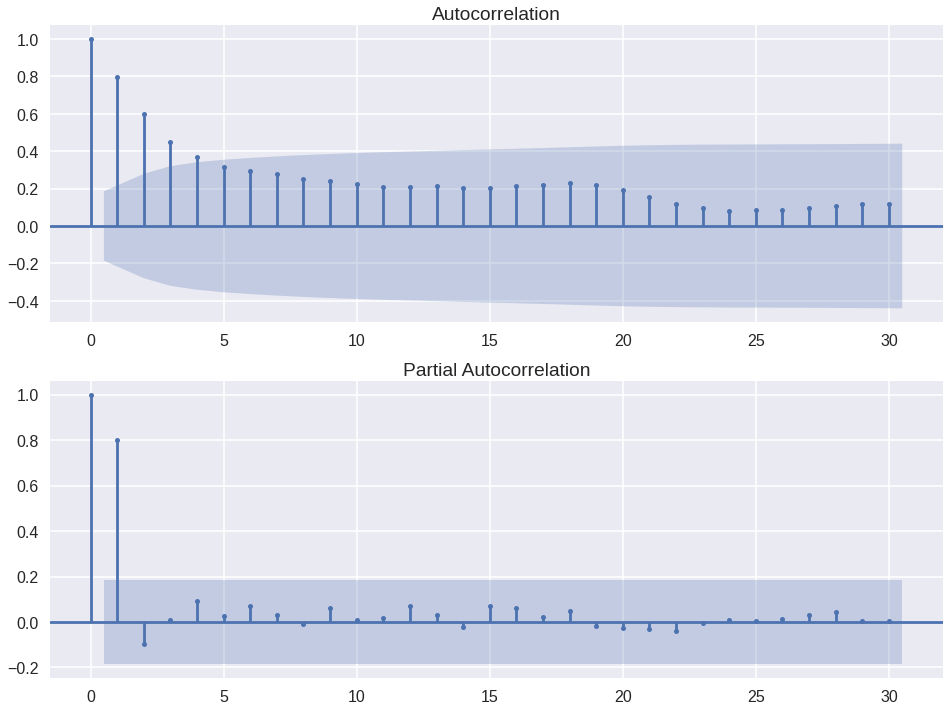

In [15]:
plt.style.use('seaborn-poster')
f, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16, 12))
plot_acf(series['Weighted_Price'], lags = 30, ax = ax[0])
plot_pacf(series['Weighted_Price'], lags = 30, ax = ax[1])
plt.show()

In [16]:
def stationarity_test(series):
    test = adfuller(series, autolag = 'AIC')
    results = pd.Series(test[0 : 4], \
                index = ['ADF Statistic', 'p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in test[4].items():
        results['Critical Value (%s)'%key] = value
    
    print("ADF Results")
    display(results)

In [17]:
stationarity_test(series['Weighted_Price'])

ADF Results


ADF Statistic                    2.143886
p-value                          0.998833
#Lags Used                       1.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64

In [18]:
series['Weighted_Price_Box_Transform'], lmbda = stats.boxcox(series['Weighted_Price'])

In [19]:
stationarity_test(series['Weighted_Price_Box_Transform'])

ADF Results


ADF Statistic                   -0.293579
p-value                          0.926409
#Lags Used                       1.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64

In [20]:
series['Weighted_Price_Box_Seasonal_Diff'] = series.Weighted_Price_Box_Transform - series.Weighted_Price_Box_Transform.shift(12)

In [21]:
display(series)

,Weighted_Price,Weighted_Price_Box_Transform,Weighted_Price_Box_Seasonal_Diff
Timestamp,,,
2011-12-31,4.471603,1.633738,NaN
2012-01-31,6.345955,2.057681,NaN
2012-02-29,5.228443,1.821004,NaN
2012-03-31,4.984397,1.763401,NaN
2012-04-30,4.995091,1.765977,NaN
...,...,...,...
2020-11-30,16535.990325,17.816633,2.001607
2020-12-31,21811.782847,18.671514,3.249221
2021-01-31,34552.337249,20.152969,4.341819


In [22]:
stationarity_test(series['Weighted_Price_Box_Seasonal_Diff'][12:])

ADF Results


ADF Statistic                  -1.678562
p-value                         0.442190
#Lags Used                     12.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64

In [23]:
series['Weighted_Price_Box_Diff'] = series.Weighted_Price_Box_Seasonal_Diff - series.Weighted_Price_Box_Seasonal_Diff.shift(1)

In [24]:
display(series)

,Weighted_Price,Weighted_Price_Box_Transform,Weighted_Price_Box_Seasonal_Diff,Weighted_Price_Box_Diff
Timestamp,,,,
2011-12-31,4.471603,1.633738,NaN,NaN
2012-01-31,6.345955,2.057681,NaN,NaN
2012-02-29,5.228443,1.821004,NaN,NaN
2012-03-31,4.984397,1.763401,NaN,NaN
2012-04-30,4.995091,1.765977,NaN,NaN
...,...,...,...,...
2020-11-30,16535.990325,17.816633,2.001607,1.005741
2020-12-31,21811.782847,18.671514,3.249221,1.247615
2021-01-31,34552.337249,20.152969,4.341819,1.092598


In [25]:
stationarity_test(series['Weighted_Price_Box_Diff'][13:])

ADF Results


ADF Statistic                  -4.972855
p-value                         0.000025
#Lags Used                     11.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64

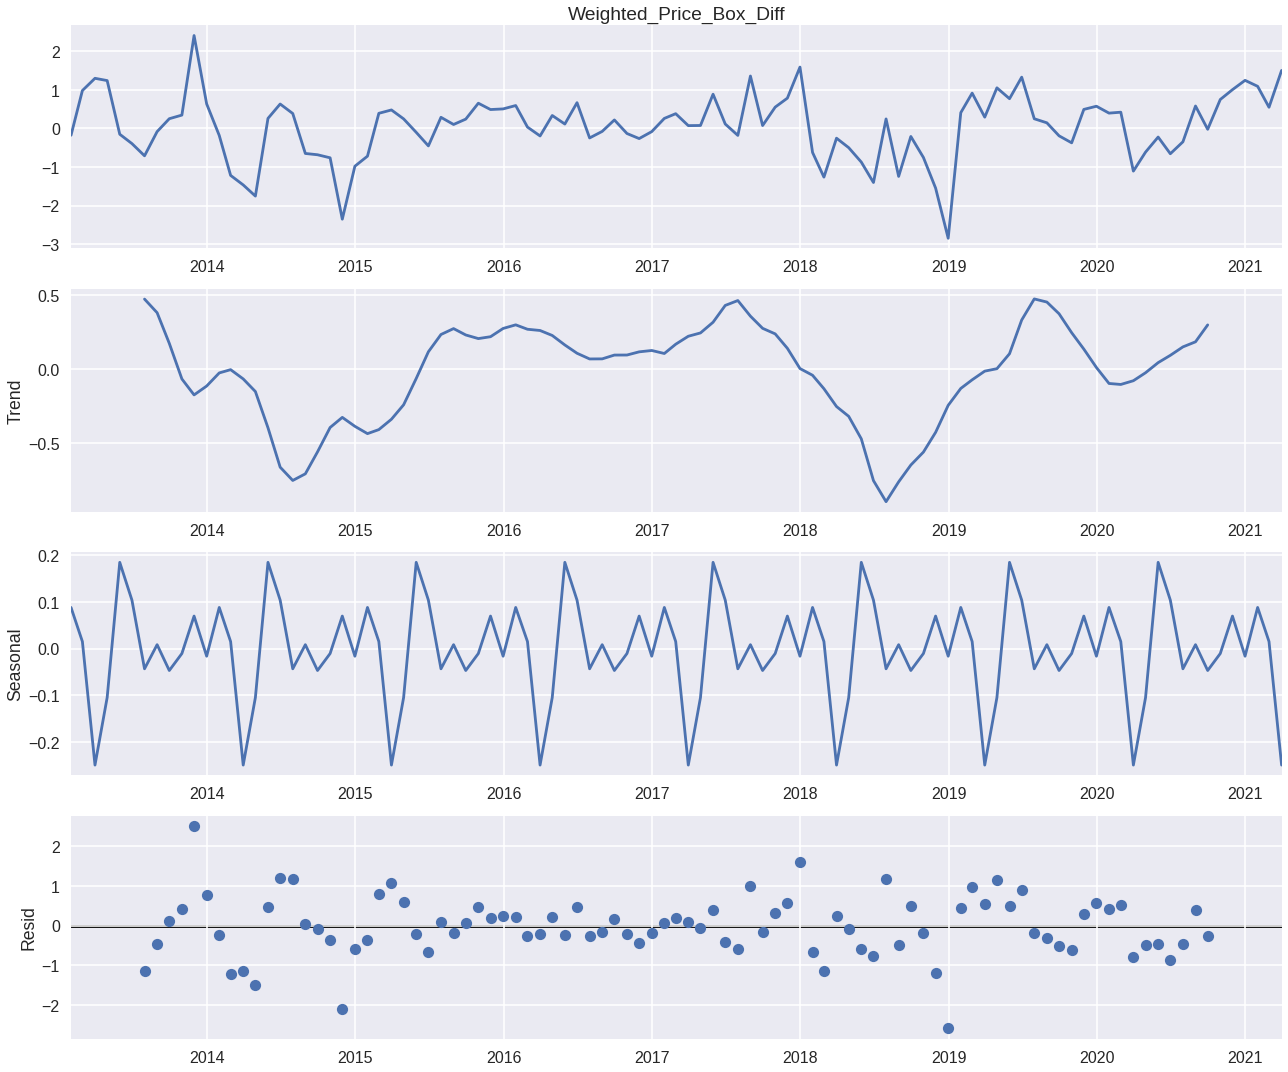

In [26]:
decomposition = seasonal_decompose(series['Weighted_Price_Box_Diff'][13:], model = 'additive')
rcParams['figure.figsize'] = 18, 15
decomposition.plot()
plt.show()

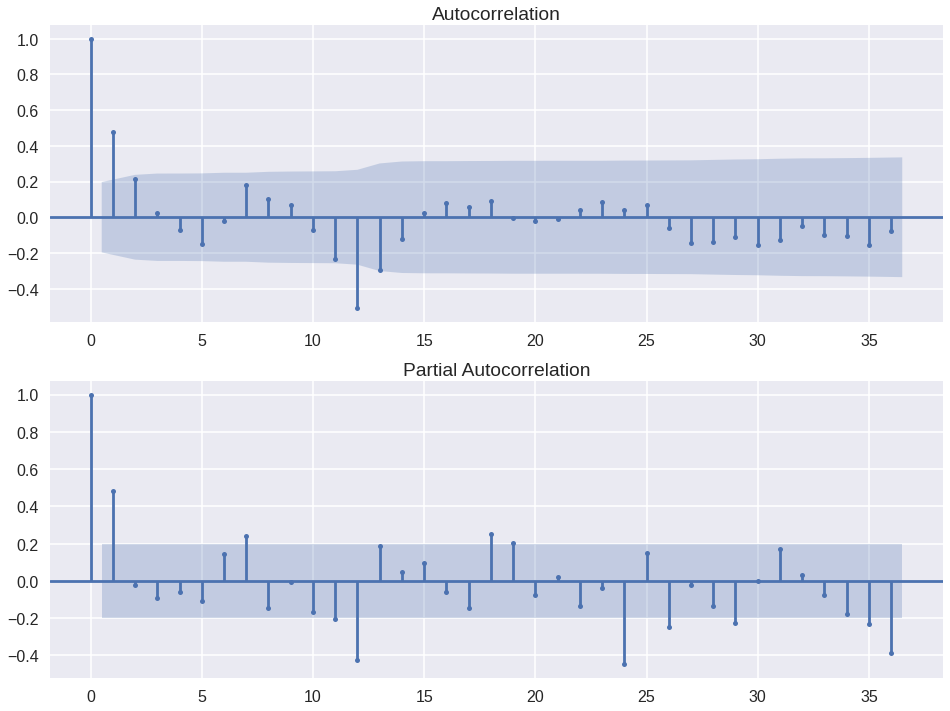

In [27]:
plt.style.use('seaborn-poster')
f, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16, 12))
plot_acf(series['Weighted_Price_Box_Diff'][13:], lags = 36, ax = ax[0])
plot_pacf(series['Weighted_Price_Box_Diff'][13:], lags = 36, ax = ax[1])
plt.show()

In [28]:
def inverse_transform(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [29]:
tscv = TimeSeriesSplit(n_splits = 3)

Ps = [0, 1, 7]
ps = [0, 1, 7]
Qs = [0, 1, 2]
qs = [0, 1, 2]

D = 1
d = 1
S = 12
parameters = list(product(ps, qs, Ps, Qs))

tic = time.time()
results = []
best_metric = np.inf
best_combination, best_model = None, None
for combination in parameters:
    p, q, P, Q = combination[0], combination[1], combination[2], combination[3]
    print("Combination: p = {}, d = {}, q = {}, P = {}, D = {}, Q = {}".format(p, d, q, P, D, Q))
    order = (p, d, q)
    seasonal_order = (P, D, Q, S)
    
    try:
        model_aics = []
        mean_squared_errors = []
        for step, (train_idx, valid_idx) in enumerate(tscv.split(series['Weighted_Price_Box_Transform'])):
            train_series = series['Weighted_Price_Box_Transform'][train_idx]
            valid_series = series['Weighted_Price'][valid_idx]

            model = SARIMAX(train_series, order = order, seasonal_order = seasonal_order)
            model_fit = model.fit()

            forecast = model_fit.predict(start = valid_series.index[0], end = valid_series.index[-1])
            predictions = inverse_transform(forecast, lmbda)
            error = np.sqrt(mean_squared_error(predictions, valid_series))

            model_aics.append(model_fit.aic)
            mean_squared_errors.append(error)
   
        model_aic   = np.mean(model_aics)
        model_error = np.mean(mean_squared_errors)
        average     = 0.5 * model_aic + 0.5 * model_error

        metric = average

        if metric < best_metric:
            best_metric = metric
            best_combination = combination

        results.append([combination, model_aic, model_error, average])
        
    except:
        pass
    
toc = time.time()
print("Time for the hyperparameters search: {}'s".format(toc - tic))

Combination: p = 0, d = 1, q = 0, P = 0, D = 1, Q = 0
Combination: p = 0, d = 1, q = 0, P = 0, D = 1, Q = 1
Combination: p = 0, d = 1, q = 0, P = 0, D = 1, Q = 2
Combination: p = 0, d = 1, q = 0, P = 1, D = 1, Q = 0
Combination: p = 0, d = 1, q = 0, P = 1, D = 1, Q = 1
Combination: p = 0, d = 1, q = 0, P = 1, D = 1, Q = 2
Combination: p = 0, d = 1, q = 0, P = 7, D = 1, Q = 0
Combination: p = 0, d = 1, q = 0, P = 7, D = 1, Q = 1
Combination: p = 0, d = 1, q = 0, P = 7, D = 1, Q = 2
Combination: p = 0, d = 1, q = 1, P = 0, D = 1, Q = 0
Combination: p = 0, d = 1, q = 1, P = 0, D = 1, Q = 1
Combination: p = 0, d = 1, q = 1, P = 0, D = 1, Q = 2
Combination: p = 0, d = 1, q = 1, P = 1, D = 1, Q = 0
Combination: p = 0, d = 1, q = 1, P = 1, D = 1, Q = 1
Combination: p = 0, d = 1, q = 1, P = 1, D = 1, Q = 2
Combination: p = 0, d = 1, q = 1, P = 7, D = 1, Q = 0
Combination: p = 0, d = 1, q = 1, P = 7, D = 1, Q = 1
Combination: p = 0, d = 1, q = 1, P = 7, D = 1, Q = 2
Combination: p = 0, d = 1, q

In [30]:
results = pd.DataFrame(results, columns = ['Parameters', 'AIC', "MSE Errors", "0.5 * AIC + 0.5 * MSE"])
display(results.sort_values(by = 'AIC', ascending=True).head(n = 10))
display(results.sort_values(by = 'MSE Errors', ascending=True).head(n = 10))
display(results.sort_values(by = '0.5 * AIC + 0.5 * MSE', ascending=True).head(n = 10))

,Parameters,AIC,MSE Errors,0.5 * AIC + 0.5 * MSE
31,"(1, 0, 1, 1)",79.033611,7434.904134,3756.968872
22,"(0, 2, 1, 1)",80.306675,7433.395089,3756.850882
29,"(1, 0, 0, 2)",80.543263,6288.375644,3184.459454
30,"(1, 0, 1, 0)",80.641757,7893.093491,3986.867624
13,"(0, 1, 1, 1)",80.695142,7334.947188,3707.821165
40,"(1, 1, 1, 1)",80.860770,7455.264282,3768.062526
32,"(1, 0, 1, 2)",80.866312,7428.419196,3754.642754
28,"(1, 0, 0, 1)",81.044699,6040.923776,3060.984237
23,"(0, 2, 1, 2)",81.508906,7460.519534,3771.014220
56,"(7, 0, 0, 2)",81.555240,9385.485881,4733.520560


,Parameters,AIC,MSE Errors,0.5 * AIC + 0.5 * MSE
28,"(1, 0, 0, 1)",81.044699,6040.923776,3060.984237
37,"(1, 1, 0, 1)",82.757289,6244.804595,3163.780942
19,"(0, 2, 0, 1)",81.766416,6263.269462,3172.517939
29,"(1, 0, 0, 2)",80.543263,6288.375644,3184.459454
10,"(0, 1, 0, 1)",82.359510,6329.867285,3206.113397
1,"(0, 0, 0, 1)",88.266813,6363.465340,3225.866076
38,"(1, 1, 0, 2)",82.331046,6425.699217,3254.015131
20,"(0, 2, 0, 2)",81.700908,6507.385532,3294.543220
11,"(0, 1, 0, 2)",81.817365,6514.629496,3298.223431
2,"(0, 0, 0, 2)",87.086850,6564.569973,3325.828411


,Parameters,AIC,MSE Errors,0.5 * AIC + 0.5 * MSE
28,"(1, 0, 0, 1)",81.044699,6040.923776,3060.984237
37,"(1, 1, 0, 1)",82.757289,6244.804595,3163.780942
19,"(0, 2, 0, 1)",81.766416,6263.269462,3172.517939
29,"(1, 0, 0, 2)",80.543263,6288.375644,3184.459454
10,"(0, 1, 0, 1)",82.359510,6329.867285,3206.113397
1,"(0, 0, 0, 1)",88.266813,6363.465340,3225.866076
38,"(1, 1, 0, 2)",82.331046,6425.699217,3254.015131
20,"(0, 2, 0, 2)",81.700908,6507.385532,3294.543220
11,"(0, 1, 0, 2)",81.817365,6514.629496,3298.223431
2,"(0, 0, 0, 2)",87.086850,6564.569973,3325.828411


In [31]:
p, q, P, Q = best_combination[0], best_combination[1], best_combination[2], best_combination[3]

order = (p, 1, q)
seasonal_order = (P, 1, Q, 12)

best_model = SARIMAX(series['Weighted_Price_Box_Transform'], order = order, seasonal_order = seasonal_order)
best_model_fit = best_model.fit()

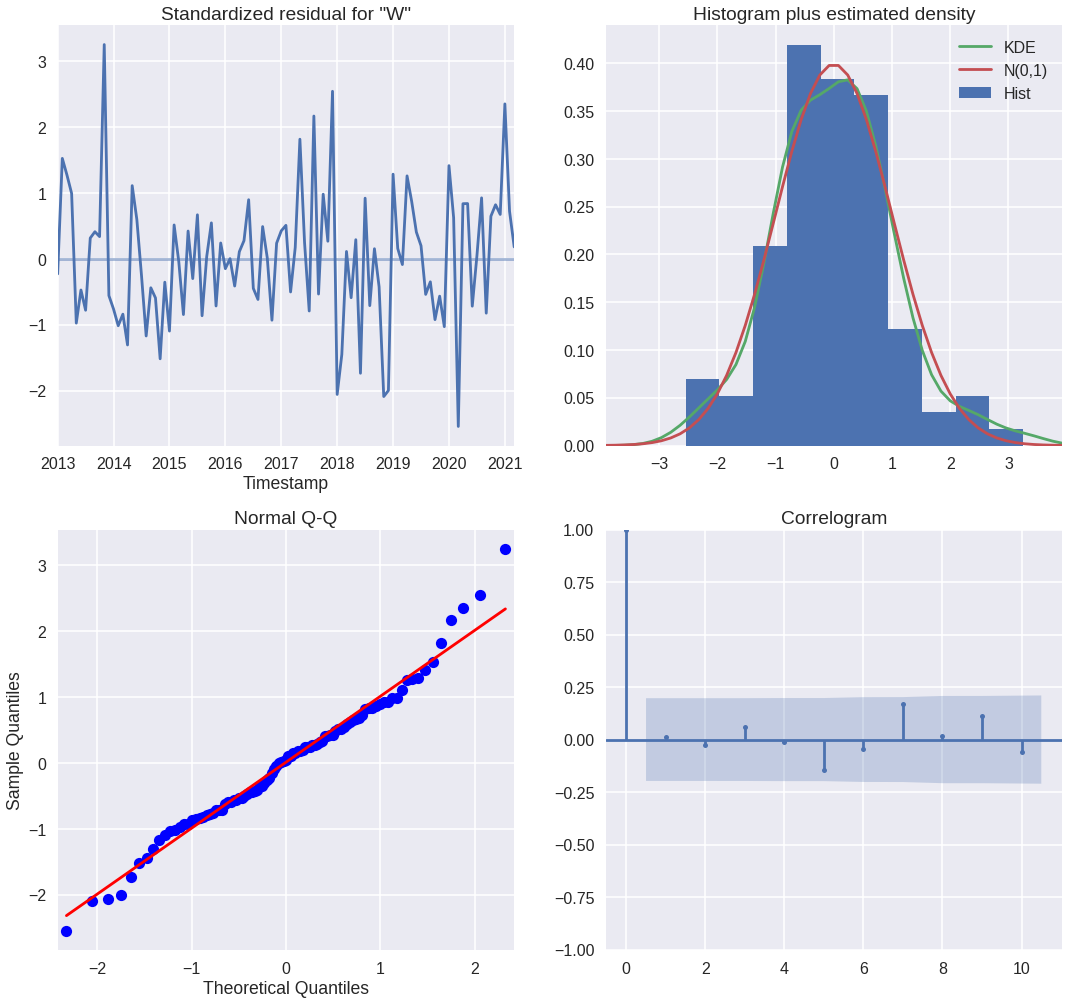

In [32]:
plt.style.use('seaborn-poster')
best_model_fit.plot_diagnostics(figsize = (18, 17));

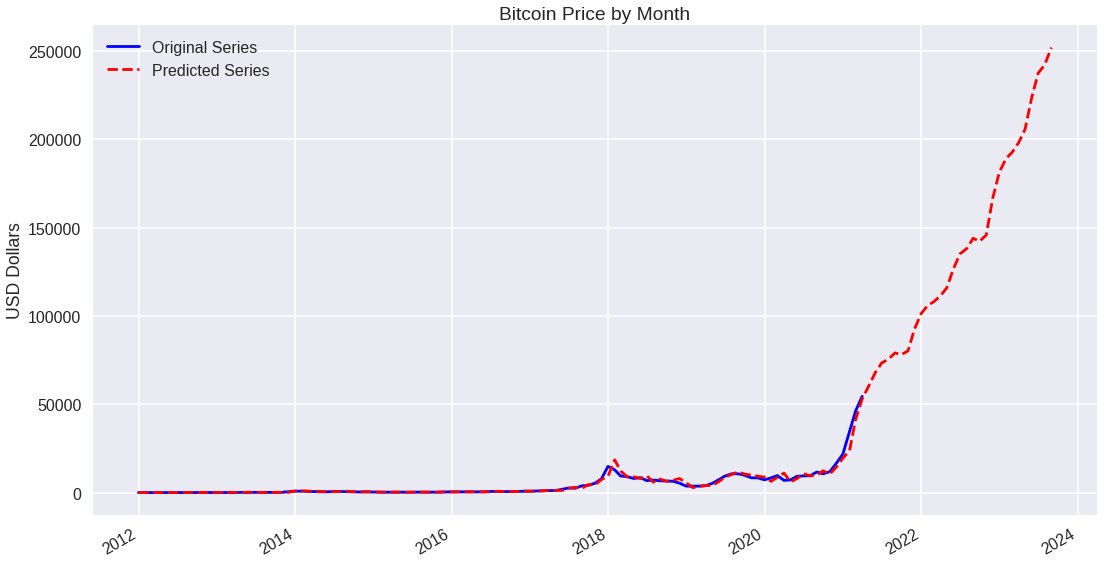

In [33]:
timestamps = pd.date_range(start = series.index[-1], periods = 30, freq = 'M')
original   = series[['Weighted_Price']]
future     = pd.DataFrame(index = timestamps, columns = original.columns)

predicted = pd.concat([original, future])
predicted['Forecast'] = inverse_transform(best_model_fit.predict(start = predicted.index[0], end = predicted.index[-1]), lmbda)
                                         
plt.figure(figsize=(18, 10))
predicted['Weighted_Price'].plot(color = 'blue', label = 'Original Series')
predicted['Forecast'].plot(color='r', ls='--', label = 'Predicted Series')
plt.title('Bitcoin Price by Month')
plt.ylabel('USD Dollars')
plt.legend(loc = 'best')
plt.show()